In [1]:
# print_function for compatibility with Python 3
from __future__ import print_function
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)


# Matplotlib for visualization
from matplotlib import pyplot as plt

# display plots in the notebook
%matplotlib inline 


# Seaborn for easier visualization
import seaborn as sns 
# Scikit-Learn for Modeling
import sklearn 
# Pickle for saving model files
import pickle 

In [2]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
# Function for splitting training and test set
from sklearn.model_selection import train_test_split
# Function for creating model pipelines
from sklearn.pipeline import make_pipeline
# For standardization
from sklearn.preprocessing import StandardScaler
# Helper for cross-validation
from sklearn.model_selection import GridSearchCV
# Classification metrics (added later)
from sklearn.metrics import roc_curve, auc

In [4]:
# Load analytical base table from Module 2
df = pd.read_csv('analytical_base_table.csv')

In [5]:
# Create separate object for target variable
y = df.status

# Create separate object for input features
X = df.drop('status', axis=1)

In [6]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=df.status)

# Print number of observations in X_train, X_test, y_train, and y_test
print (len(X_train), len(X_test), len(y_train), len(y_test))

11254 2814 11254 2814


In [7]:
# Pipeline dictionary
pipeline_dict = {'l1': make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=123)), 
                                     'l2': make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=123)),
                                     'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
                                     'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
                }

In [8]:
# List tuneable hyperparameters of our Logistic pipeline
pipeline_dict['l1'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l1', random_state=123, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=123, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logis

In [9]:
# Logistic Regression hyperparameters
l1_hyperparameters = { 'logisticregression__C': np.linspace(1e-3, 1e3, 10)}
l2_hyperparameters = { 'logisticregression__C': np.linspace(1e-3, 1e3, 10)}

In [10]:
# Random Forest hyperparameters
rf_hyperparameters = { 'randomforestclassifier__n_estimators': [100, 200],
                         'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]}

In [11]:
# Boosted Tree hyperparameters
gb_hyperparameters = {'gradientboostingclassifier__n_estimators': [100, 200], 
                    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2], 
                     'gradientboostingclassifier__max_depth': [1, 3, 5]}

In [12]:
# Create hyperparameters dictionary
hp_dict = { 'l1': l1_hyperparameters, 'l2': l2_hyperparameters, 'rf': rf_hyperparameters, 'gb': gb_hyperparameters}

In [13]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipeline_dict.items(): 
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hp_dict[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted')

l1 has been fitted
l2 has been fitted
rf has been fitted
gb has been fitted


In [14]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_score_)

l1 0.8493868846632309
l2 0.8493868846632309
rf 0.9794739648125111
gb 0.9752976719388662


In [15]:
# Classification metrics
from sklearn.metrics import roc_curve, auc

In [16]:
# Predict classes using L1-regularized logistic regression 
pred = fitted_models['l1'].predict(X_test)

# Display first 10 predictions
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

In [17]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Display confusion matrix for y_test and pred
print (confusion_matrix(y_test, pred))

[[1969  172]
 [ 221  452]]


In [18]:
# Predict PROBABILITIES using L1-regularized logistic regression
pred = fitted_models['l1'].predict_proba(X_test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

# Display first 10 predictions
pred[:10]

[0.030570349259667114,
 0.004442558910760174,
 0.007296407726425731,
 0.08809450674953327,
 0.07114992041649947,
 0.4816119884163121,
 0.12605150841071125,
 0.6152969576779703,
 0.7266637172027661,
 0.13704030892783006]

In [19]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)

In [20]:
# Store fpr, tpr, thresholds in DataFrame and display last 10
pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Thresholds': thresholds}).tail(10)

,FPR,TPR,Thresholds
530,0.759925,0.994056,0.009627
531,0.784680,0.994056,0.008120
532,0.784680,0.995542,0.008077
533,0.910322,0.995542,0.001963
534,0.910322,0.997028,0.001950
535,0.932742,0.997028,0.001393
536,0.932742,0.998514,0.001388
537,0.949089,0.998514,0.001051
538,0.949089,1.000000,0.001040
539,1.000000,1.000000,0.000027


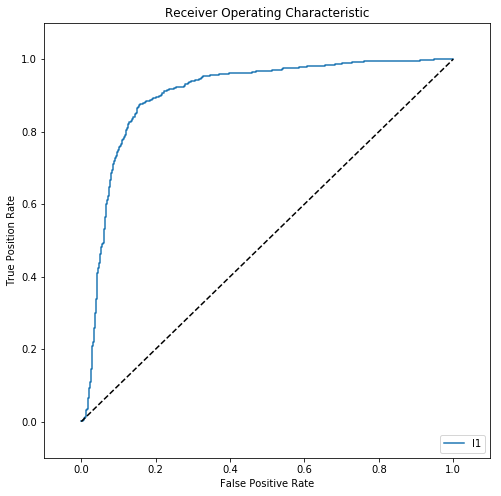

In [21]:
# Initialize figure
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1], 'k--')

# Axes limits and labels
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Position Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [22]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred)
# Calculate AUROC
print(auc(fpr, tpr))

0.9015395313878269


In [28]:
# Code here
for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print(name)


l1
l2
rf
gb


In [27]:
# Save winning model as final_model.pkl
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)